In [5]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [70]:
sys.path.append('/usr/local/Cellar/openjpeg/2.3.0')

In [6]:
import glymur
#! which glymur
# https://nbviewer.jupyter.org/github/vathes/Datajoint_Interface/blob/master/demo/distributed-image-processing.ipynb?refresh=True

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

import tempfile
import datajoint as dj
from minio import Minio
from os import path
import json
import re


from utilities import *
# Connect to datajoint server
dj.conn()

Connecting alex@ucsd-demo-db.datajoint.io:3306


DataJoint connection (connected) alex@ucsd-demo-db.datajoint.io:3306

In [8]:
# Define which schema you're using
schema = dj.schema('common_atlas')

In [9]:
# load S3 access_key and secret_key
# The file s3-creds.json should contain the following:
# {"access_key": "...", "secret_key": "..."}

# with open('/Users/newberry/Desktop/atlas_data/alex_aws_credentials.json') as f:
#     creds = json.load(f)
def get_s3_client():
    with open('/Users/newberry/Desktop/atlas_data/alex_aws_credentials.json') as f:
        creds = json.load(f)
    return Minio('s3.amazonaws.com', secure=True, **creds)

In [10]:
BaseImage.drop()

NameError: name 'BaseImage' is not defined

In [11]:
@schema
class BaseImage(dj.Manual):
    definition = '''
    image_id:          int            # image id
    ---
    image_location:    varchar(1024)  # image location in bucket
    filesize : bigint  # (bytes)
    '''
    
    bucket_name = 'mousebraindata-open'
    
    @classmethod
    def fill(cls):   
        """
        fill the image list from the bucket
        """
        client = get_s3_client()
        objects = client.list_objects(BaseImage.bucket_name, prefix='MD657/')
        cls.insert(
            dict(image_id=i, image_location=obj.object_name, filesize=obj.size) 
            for i, obj in enumerate(objects) if obj.object_name.endswith('.jp2'))

In [12]:
if not BaseImage(): 
    # load directory from the repository
    BaseImage.fill()

In [13]:
BaseImage()

image_id image id,image_location image location in bucket,filesize (bytes)
3,MD657/MD657-F1-2017.02.17-17.39.26_MD657_1_0001_lossless.jp2,954508035
6,MD657/MD657-F1-2017.02.17-17.39.26_MD657_1_0001_lossy.jp2,14478371
9,MD657/MD657-F1-2017.02.17-17.39.26_MD657_2_0002_lossless.jp2,899927072
12,MD657/MD657-F1-2017.02.17-17.39.26_MD657_2_0002_lossy.jp2,15245894
15,MD657/MD657-F1-2017.02.17-17.39.26_MD657_3_0003_lossless.jp2,926556190
18,MD657/MD657-F1-2017.02.17-17.39.26_MD657_3_0003_lossy.jp2,15207827
21,MD657/MD657-F10-2017.02.17-19.35.42_MD657_1_0028_lossless.jp2,1419405381


In [14]:
@schema
class BaseProperties(dj.Computed):
    definition = """
    # Image properties inferred from file name
    -> BaseImage
    ---
    prep : varchar(16)
    image_datetime : datetime
    letter_number : char(8)
    major : smallint
    minor : smallint
    lossy : bool
    """
    def make(self, key):
        path = (BaseImage & key).fetch1('image_location')
        match = re.match(
            r'(?P<prep>\w*)/(?P=prep)-(?P<letter_number>\w*)-'
            r'(?P<date>\d{4}\.\d\d\.\d\d)-(?P<time>\d\d\.\d\d\.\d\d)_(?P=prep)_'
            r'(?P<major>\d+)_(?P<minor>\d+)_(?P<lossy>(lossy|lossless))\.jp2', path).groupdict()
        match['image_datetime'] = str.replace(match['date'], '.', '-') + ' ' + str.replace(match['time'], '.', ':')
        match['lossy'] = match['lossy'] == 'lossy' 
        self.insert1(dict(key, **match),  ignore_extra_fields=True)
        
@schema
class Thumbnail(dj.Imported):
    definition = """
    # Downsampled images from BaseImage
    -> BaseProperties
    ---
    image_width :  int  # (Voxels) original image width 
    image_height :  int  # (voxels) original image height
    image_depth : int # (voxels) original image depth (e.g. 3 for RGB)
    downsample : smallint  
    thumbnail : longblob
    """
    
    def make(self, key):
        path = (BaseImage & key).fetch1('image_location')
        client = get_s3_client()
        data = client.get_object(BaseImage.bucket_name, path).data
        f = tempfile.NamedTemporaryFile(delete=False)
        f.write(data)
        f.close()
        img = glymur.Jp2k(f.name)
        d = 32
        self.insert1(dict(
            key, 
            **dict(zip(('image_height', 'image_width', 'image_depth'), img.shape)), 
            downsample=d, thumbnail=np.uint8(np.maximum(0, np.minimum(255, img[::d, ::d, :])))))

In [15]:
BaseProperties.populate(display_progress=True)

0it [00:00, ?it/s]


In [16]:
#BaseProperties()
BaseProperties * BaseImage & {'lossy': True}

image_id image id,prep,image_datetime,letter_number,major,minor,lossy,image_location image location in bucket,filesize (bytes)
6,MD657,2017-02-17 17:39:26,F1,1,1,1,MD657/MD657-F1-2017.02.17-17.39.26_MD657_1_0001_lossy.jp2,14478371
12,MD657,2017-02-17 17:39:26,F1,2,2,1,MD657/MD657-F1-2017.02.17-17.39.26_MD657_2_0002_lossy.jp2,15245894
18,MD657,2017-02-17 17:39:26,F1,3,3,1,MD657/MD657-F1-2017.02.17-17.39.26_MD657_3_0003_lossy.jp2,15207827
24,MD657,2017-02-17 19:35:42,F10,1,28,1,MD657/MD657-F10-2017.02.17-19.35.42_MD657_1_0028_lossy.jp2,36016872
30,MD657,2017-02-17 19:35:42,F10,3,30,1,MD657/MD657-F10-2017.02.17-19.35.42_MD657_3_0030_lossy.jp2,36485376
36,MD657,2017-02-21 17:57:42,F10,1,28,1,MD657/MD657-F10-2017.02.21-17.57.42_MD657_1_0028_lossy.jp2,25894421
42,MD657,2017-02-21 17:57:42,F10,2,29,1,MD657/MD657-F10-2017.02.21-17.57.42_MD657_2_0029_lossy.jp2,28821054


In [21]:
Thumbnail.populate('lossy=0', display_progress=True, reserve_jobs=True, limit=2)


100%|██████████| 2/2 [01:00<00:00, 30.11s/it]


In [22]:
Thumbnail()

image_id image id,image_width (Voxels) original image width,image_height (voxels) original image height,image_depth (voxels) original image depth (e.g. 3 for RGB),downsample,thumbnail
9,22608,20802,3,32,=BLOB=


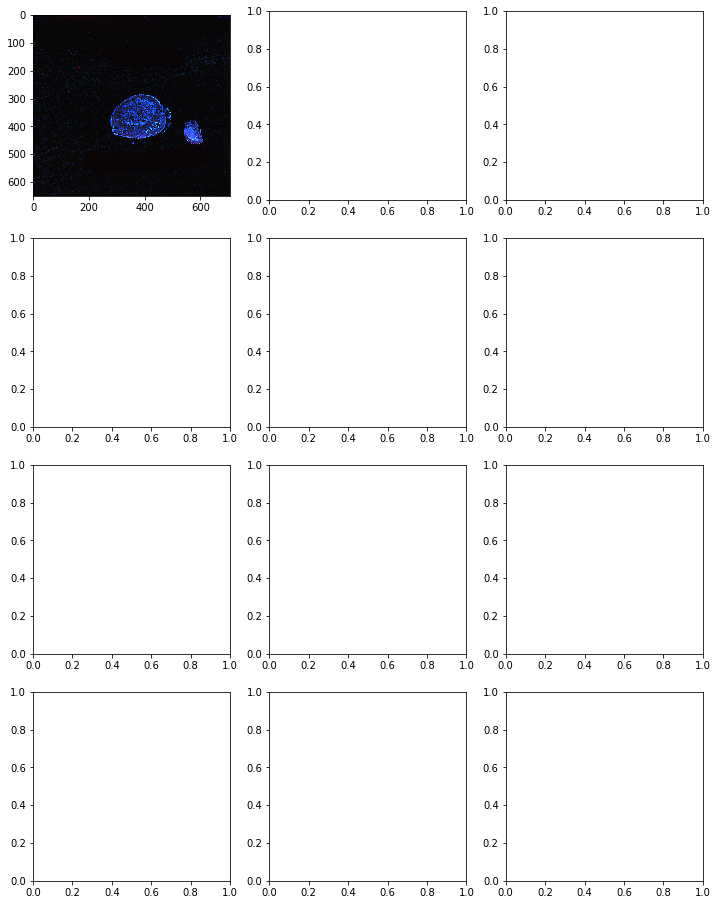

In [23]:
fig, ax = plt.subplots(4, 3, figsize=(12,16))
for a, thumb in zip(ax.flatten(), Thumbnail()):
    a.imshow(np.maximum(0, np.minimum(255, thumb['thumbnail'])))

# Tutorial Schema

In [71]:
Mouse.drop()

`common_atlas`.`mouse` (0 tuples)
`common_atlas`.`injection` (0 tuples)
`common_atlas`.`histology` (0 tuples)
`common_atlas`.`brain_stack_info` (0 tuples)
`common_atlas`.`__raw_stack` (0 tuples)
`common_atlas`.`__processed_stack` (0 tuples)
Proceed? [yes, No]: yes
Tables dropped.  Restart kernel.


In [72]:
@schema
class Mouse(dj.Manual):
    definition = """
    mouse : char(18)               # Name for lab mouse, max 8 chars
    -------
    date_of_birth  : date          # (date) the mouse's date of birth
    sex            : enum('M','F') # (M/F) either 'M' for male, 'F' for female
    genotype       : varchar(10)   # (Str) indicating the genotype
    weight         : double        # (int) weight of the mouse in grams. -1 if unknown
    bred           : varchar(20)   # (Str) Vendor where the mouse was bred (bred in house, purchased by vendor)
    """
    
@schema
class Perfusion(dj.Manual): # Everyone should be doing the same type of perfusion
    definition = """
    -> Mouse                        # One injection per mouse
    ----------
    injection_date  : date          # (date) what day was the injection performed

    post_fixation_condition_hours : int   # (int) How long kept in fix (overnight)
    #percent_sucrose_of_fix        : int   # (int) 10 or 20 percent for CSHL stuff

    date_frozen    : date     # (date) The date the brain was frozen
    date_sectioned : date     # (date) The date the brain was sectioned

    injection_type  : varchar(30)   # (Str) what kind of tracer/injection
    perfusion_lab   : varchar(30)   # (Str) Which lab perfused the mouse? This lab also kept the mouse
    
    assessment=''   : varchar(1000) # (Str) optional, qualitative assessment of injection
    """
    
@schema
class Injection(dj.Manual): # Viral injections
    definition = """
    -> Mouse                        # One injection per mouse
    injection_number : int          # iterative, how many injections have already been performed
    -------
    injection_date  : date          # (date) what day was the injection performed
    injection_type  : varchar(30)   # (Str) what kind of tracer/injection (flourescent?)
    injection_length: int           # UNSURE. Assumed: the length of time the virus was allowed to propagate
    
    assessment=''   : varchar(1000) # (Str) qualitative assessment of injection
    """
    
@schema
class Histology(dj.Manual):
    definition = """
    -> Mouse                        # One Histology per injection per mouse
    ------------
    region         : varchar(10)    # (Str) ?
    thickness      : int            # (int) thickness of each slice in microns
    orientation    : enum('sagittal','coronal','horozontal')    # (Str) horizontal, sagittal, coronal
    counter_stain  : varchar(30)    # (Str) what stain was used on the brain (thionin or NeuroTrace)
    lab            : varchar(20)    # (Str) Which lab did the histology
    series         : enum('all','every other','unknown') # Every section OR alternate sections
    """
# AFTER sectioning, the reporter can either be directly visualized with fuorscence or needs to be 
#  amplified with immunostaining
# Hannah, with Axio Scanner, will manually select level of exposure to reduce saturation but make sure the 
#  the fluorescent molecules are visible
#    - add: CSHL_did_their_own_blackbox_preprocessing : True or False
# Assume calibration, we don't do 


@schema 
class BrainStackInfo(dj.Manual):
    definition = """
    -> Histology            # One Histology per injection per mouse
    ------------
    stack_name       : varchar(10)   # (Str) unique designation for each mouse
    num_slices       : int           # (int) total number of histology slices
    num_valid_slices : int 
    channels         : int           # (int) number of channels for each slice
    sorted_filenames : varchar(50000)# (Str) the sorted_filenames.txt file for each brain
    human_annotated  : boolean       # (bool) does this stack have human annotations

    planar_resolution_um : double    # (double) 0.325 for AxioScanner, 0.46 from CSHL
    section_thickness_um : double    # (double) typically 20um
    
    unique index (stack_name)   # Adds constraint, stack name must be unique accross brains
    """
@schema
class RawStack(dj.Computed):
    definition = """
    -> BrainStackInfo
    -----------------
    aws_bucket : varchar(40)     # (Str) the name of the bucket the files are stored on
    raw_stack  : varchar(50000)  # (Str) a sequence of each filepath of files stored on S3 seperated by '|'
    """
    def make(self, key):
        brain_stack_info = (BrainStackInfo()&key).fetch( as_dict=True )[0]

        stack = brain_stack_info["stack_name"] # OR ["mouse"]
        
        key['aws_bucket'] = "mousebrainatlas-rawdata"
        key['raw_stack'] = get_raw_files( stack, returntype="string" )
        
        self.insert1(key)
        
@schema
class ProcessedStack(dj.Computed):
    definition = """
    -> BrainStackInfo
    ---
    aws_bucket : varchar(40)     # (Str) the name of the bucket the files are stored on
    processed_stack  : varchar(50000)  # (Str) a sequence of each filepath of files stored on S3 seperated by '|'
    """
    def make(self, key):
        brain_stack_info = (BrainStackInfo()&key).fetch( as_dict=True )[0]

        stack = brain_stack_info["stack_name"] # OR ["mouse"]
        
        key['aws_bucket'] = "mousebrainatlas-data"
        key['processed_stack'] = get_processed_files( stack, prep_id="2", version="", \
                                               resol="raw", returntype="string" )
#         key['thumbnail_stack'] = get_processed_files( stack, prep_id="2", version="", \
#                                                resol="thumbnail", returntype="string" )
        
        
        self.insert1(key)

# Populate from S3

In [73]:
for brain_name in brain_names_list:
    print("\n"+brain_name+' being added')
    
    # Fill in MOUSE info
    if brain_name == 'UCSD001':
        Mouse.insert1(dict(mouse=brain_name,
                   date_of_birth='2020-01-01',
                   sex='M',
                   genotype='C57',
                   weight=-1,
                   bred='Unknown')
                 ,skip_duplicates=True)
    else:
        Mouse.insert1(dict(mouse=brain_name,
                       date_of_birth='2017-12-05',
                       sex='M',
                       genotype='C57',
                       weight=-1,
                       bred='Unknown')
                     ,skip_duplicates=True)
        
    # Fill in HISTOLOGY info
    Histology.insert1((brain_name,
                   'Unknown', # region
                   '20', # thickness
                   brain_names_dic[brain_name][3],  # orientation
                   brain_names_dic[brain_name][0],  # counter_stain
                   brain_names_dic[brain_name][1],  # lab
                   'unknown') # series  
                 ,skip_duplicates=True)
    
    # Try to load STACK_sorted_filenames.txt from AWS S3, on failure the default values are filled
    try:
        sorted_fn_data, total_slices, valid_slices = get_sorted_filenames( brain_name, returntype="string" )
    except Exception as e:
        sorted_fn_data = ""
        total_slices   = -1
        valid_slices   = -1
        print('No sorted_filenames.txt exists for '+brain_name)
        
    # Fill in BRAIN STACK INFO
    BrainStackInfo.insert1(dict(mouse=brain_name,
                            stack_name=brain_name,
                            num_slices       = total_slices,
                            num_valid_slices = valid_slices,
                            channels         = brain_names_dic[brain_name][0].count('/') + 1,
                            sorted_filenames = sorted_fn_data,
                            human_annotated  = brain_names_dic[brain_name][2],
                            planar_resolution_um = -1,
                            section_thickness_um = 20)
                 ,skip_duplicates=True)


MD585 being added

MD589 being added

MD590 being added

MD591 being added

MD592 being added

MD593 being added

MD594 being added

MD595 being added

MD598 being added

MD599 being added

MD602 being added

MD603 being added

CHATM2 being added

CHATM3 being added

CSHL2 being added
No sorted_filenames.txt exists for CSHL2

MD658 being added

MD661 being added

MD662 being added

MD635 being added

MD636 being added
No sorted_filenames.txt exists for MD636

MD639 being added
No sorted_filenames.txt exists for MD639

MD642 being added

MD652 being added

MD653 being added

MD657 being added

MD175 being added
No sorted_filenames.txt exists for MD175

UCSD001 being added


In [74]:
RawStack.populate()

In [75]:
ProcessedStack.populate()

# Adding S3 files to schema EXAMPLE

In [12]:
client = get_client()
objects = client.list_objects(bucket_name, prefix='MD657/')

#                  OBJECT INFO
        # bucket_name: mousebraindata-open 
        # object_name: b'MD657/MD657-F1-2017.02.17-17.39.26_MD657_1_0001.png' 
        # last_modified: 2018-08-29 04:16:33+00:00 
        # etag: 2ea51d17c3b6ad95209ec65aa59325cc 
        # size: 900864 
        # content_type: None
        # is_dir: False
        # metadata: None

for object in objects:
    if object.is_dir:
        print('Folder: ',object.object_name)
    if object.object_name.endswith('0088_lossless.jp2'):
        print(object.object_name)
    

Folder:  MD657/
MD657/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless.jp2
Folder:  MD657//
MD657/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_lossless.jp2
Folder:  MD657/patches/
Folder:  MD657/permuted/


In [43]:
@schema
class BaseImage(dj.Manual):
    definition = '''
    image_id:          int            # image id
    ---
    image_location:    varchar(1024)  # image location in bucket
    filesize : bigint  # (bytes)
    '''
    
    @classmethod
    def fill(cls):   
        """
        fill the image list from the bucket
        """
        client = get_client()
        objects = client.list_objects(bucket_name, prefix='MD657/')
        
        cls.insert(
            dict(image_id=i, image_location=obj.object_name, filesize=obj.size) 
            for i, obj in enumerate(objects) if obj.object_name.endswith('.jp2'))

In [44]:
# load directory from the repository
BaseImage.fill()

In [48]:
BaseImage()

image_id image id,image_location image location in bucket,filesize (bytes)
3,MD657/MD657-F1-2017.02.17-17.39.26_MD657_1_0001_lossless.jp2,954508035
6,MD657/MD657-F1-2017.02.17-17.39.26_MD657_1_0001_lossy.jp2,14478371
9,MD657/MD657-F1-2017.02.17-17.39.26_MD657_2_0002_lossless.jp2,899927072
12,MD657/MD657-F1-2017.02.17-17.39.26_MD657_2_0002_lossy.jp2,15245894
15,MD657/MD657-F1-2017.02.17-17.39.26_MD657_3_0003_lossless.jp2,926556190
18,MD657/MD657-F1-2017.02.17-17.39.26_MD657_3_0003_lossy.jp2,15207827
21,MD657/MD657-F10-2017.02.17-19.35.42_MD657_1_0028_lossless.jp2,1419405381


In [45]:
@schema
class Contrast(dj.Imported):
    definition = '''
    -> BaseImage
    ---
    contrast: float
    '''
    
    def make(self, key):
        path = (BaseImage & key).fetch1('image_location')
        client = get_client()
        data = client.get_object(bucket_name, path).data
        img = convert_binary_jp2_data_into_image(data)   # This function needs to be defined
        self.insert1(dict(key, contrast=img.std()))

In [47]:
Contrast.populate(reserve_jobs=True)   
   # This does the distributed job -- run on many instances

NameError: name 'convert_binary_jp2_data_into_image' is not defined

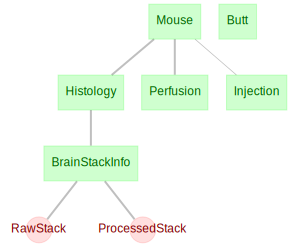

In [76]:
dj.ERD(schema)

In [ ]:
# UNUSED
@schema
class ProcessedStack(dj.Computed):
    definition = """
    -> BrainStackInfo
    """
        
    class Slice(dj.Part):
        definition = """
        -> ProcessedStack
        slice_num : int           # (int) the slice's number
        -----------
        slice_name : varchar(80)  # (Str) the slice's name
        slice_img  : blob         # (Img) the raw slice
        """

    def make(self, key):
        # Making test image
        file = open('sorted_filenames.txt')
        file_list = file.read().split('\n')
        image = np.ones((100,80))
        
        self.insert1(key)
        ProcessedStack.Slice().insert([
                dict(key, 
                     slice_num = file_list[i][1+file_list[i].index(' '):], 
                     slice_name = file_list[i][:file_list[i].index(' ')], 
                     slice_img=image)
                for i in range(0,len(file_list))  ], 
                    skip_duplicates=True)